# Esercitazione 6

## Grafico dei dati

In [154]:
import time 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
#from scipy.special import gamma

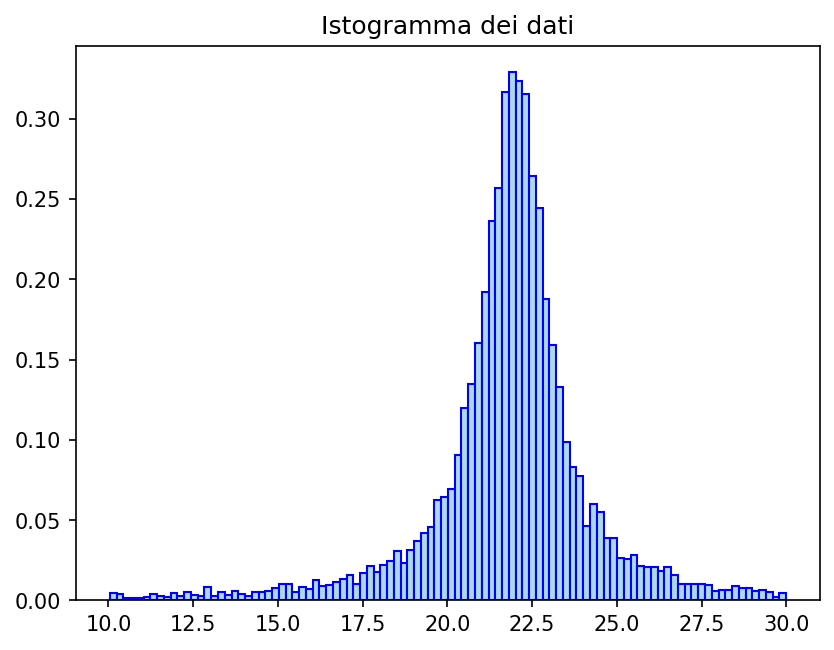

In [155]:
data = np.genfromtxt("BW.txt", delimiter=" ")

plt.figure(dpi = 150)
plt.title("Istogramma dei dati")
plt.hist(data[:, 1], bins=100, edgecolor="blue", color="lightblue", density = True)

plt.show()


## Stima dei parametri

In [156]:
# Probability distribution functions

def cauchy(x, x0, Gamma):
    # return Gamma/(np.pi * (Gamma**2 + (x - x0)**2))
    return Gamma/((Gamma**2 + (x - x0)**2))/(np.arctan((30 - x0)/Gamma) - np.arctan((10 -x0)/Gamma))

def conjCauchy(x, x0, Gamma):
    var = cauchy(x[0], x0, Gamma)
    for xi in np.nditer(x):
        var *= cauchy(xi, x0, Gamma)
    return var

def lnConjCauchy(x, x0, Gamma):
    var = np.float64(0)
    for xi in np.nditer(x):
        var += np.log(cauchy(xi, x0, Gamma))
    return var

I parametri da stimare sono $\Gamma$ e $x_0$ della funzione
$$
f(x; x_0, \Gamma) = \frac{1}{\pi} \frac{\Gamma}{\Gamma^2 + (x - x_0)^2}
$$

Il punto di massimo di probabilità della funzione si trova in $x = x_0$.

$\Gamma$ invece può essere individuato vedendo l'ampiezza a mezza altezza della curva.

In [157]:
# Number of data used to estimate parameters
sampleSize = 100

# Defining the edges of the intervals and the number of points in the intervals
x0IntervalEdges = [np.float128(20), np.float128(24)]
GammaIntervalEdges = [np.float128(0.3), np.float128(3)]

pointsx0Interval = 200
pointsGammaInterval = 100


x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)


points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))  # points[xMatrix][yMatrix][(x, y, z)]

for i in range(pointsGammaInterval):
    points[i,:,0] = x0IntervalPoints

for j in range(pointsx0Interval):
    points[:,j,1] = GammaIntervalPoints

#points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
        


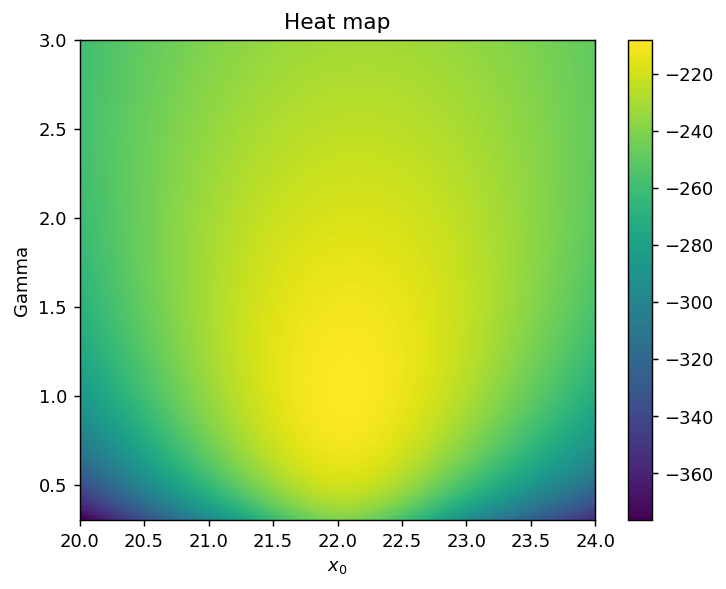

In [158]:
# Plot of the first heat map 
plt.figure(dpi= 130)
plt.title("Heat map")
plt.imshow(points[:,:,2], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="auto", origin= "lower")
#plt.imshow(points[:,:,2], origin="lower")

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

In [159]:
# Search for the maximum


precision = 0.0001
exitCondition = True # True iteration limit, False precision achieved

for k in range(1000):

    print(f"{k}: ")
    average = np.mean(points[:,:,2])
    # print(f"  Condition:  \t %1.3e" %average)
    
    # Gamma: left edge
    for i in range(pointsGammaInterval):
        if (np.max(points[i,:,2]) >= average) :
            GammaIntervalEdges[0] = points[i,0,1]
            break

    # Gamma: right edge
    for i in range(pointsGammaInterval-1, 0, -1):
        if (np.max(points[i,:,2]) >= average):
            GammaIntervalEdges[1] = points[i,0,1]
            break


    # x0: left edge
    for j in range(pointsx0Interval):
        if (np.max(points[:,j,2]) >= average):
            x0IntervalEdges[0] = points[0,j,0]
            break
        
    # x0: right edge
    for j in range(pointsx0Interval-1, 0, -1):
        if (np.max(points[:,j,2]) >= average):
            x0IntervalEdges[1] = points[0,j,0]
            break

    print(f"  Gamma in \t [ %1.6f ,"  %GammaIntervalEdges[0] + "%1.6f ]" %GammaIntervalEdges[1])
    print(f"  x0 in  \t [ %1.6f ,"  %x0IntervalEdges[0] + "%1.6f ]" %x0IntervalEdges[1])

    if (((x0IntervalEdges[1] - x0IntervalEdges[0]) <= precision) and (GammaIntervalEdges[1] - GammaIntervalEdges[0]) <= precision):
        exitCondition = False
        break

    x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

    points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
    points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
    #points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
    points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])


print("--------------------")
print("Exit Condition: ", end="")
if exitCondition:
    print("Ended for iteration limit")
else:
    print(f"Target accuracy achieved \t Accuracy = {precision}")
    print(f"Number of iterations: {k}")

GammaEstimate = np.mean(GammaIntervalEdges)
x0Estimate = np.mean(x0IntervalEdges)

print(f"Gamma: \t %1.5f" %GammaEstimate)
print(f"x0: \t %1.5f" %x0Estimate)

0: 
  Gamma in 	 [ 0.327273 ,3.000000 ]
  x0 in  	 [ 20.703518 ,23.597990 ]
1: 
  Gamma in 	 [ 0.381267 ,2.865014 ]
  x0 in  	 [ 21.008964 ,23.234363 ]
2: 
  Gamma in 	 [ 0.456532 ,2.463600 ]
  x0 in  	 [ 21.187891 ,23.010705 ]
3: 
  Gamma in 	 [ 0.497079 ,2.139226 ]
  x0 in  	 [ 21.343609 ,22.836667 ]
4: 
  Gamma in 	 [ 0.563428 ,1.907003 ]
  x0 in  	 [ 21.463654 ,22.694114 ]
5: 
  Gamma in 	 [ 0.617714 ,1.717002 ]
  x0 in  	 [ 21.568768 ,22.576633 ]
6: 
  Gamma in 	 [ 0.673234 ,1.572651 ]
  x0 in  	 [ 21.654867 ,22.480404 ]
7: 
  Gamma in 	 [ 0.718659 ,1.463631 ]
  x0 in  	 [ 21.729539 ,22.401584 ]
8: 
  Gamma in 	 [ 0.763809 ,1.373331 ]
  x0 in  	 [ 21.786950 ,22.337419 ]
9: 
  Gamma in 	 [ 0.806906 ,1.305607 ]
  x0 in  	 [ 21.836741 ,22.287628 ]
10: 
  Gamma in 	 [ 0.842168 ,1.245158 ]
  x0 in  	 [ 21.875259 ,22.244578 ]
11: 
  Gamma in 	 [ 0.870662 ,1.204452 ]
  x0 in  	 [ 21.908665 ,22.209317 ]
12: 
  Gamma in 	 [ 0.897635 ,1.167364 ]
  x0 in  	 [ 21.935859 ,22.182122 ]
13: 
  Ga

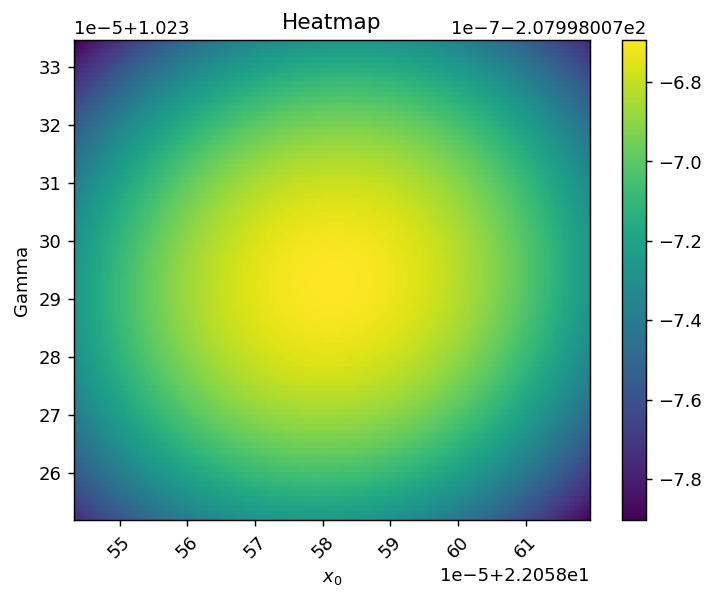

In [160]:
# Heat map after the search for the maximum

plt.figure(dpi= 130)
plt.title("Heatmap")
plt.imshow(points[:,:,2], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="auto", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

### Istogramma + Distribuzione di Cauchy

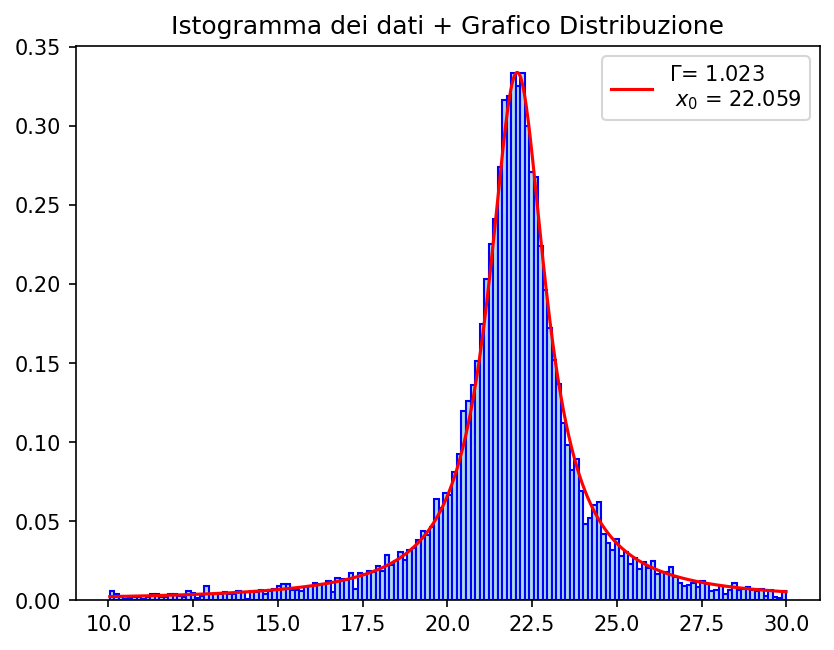

In [161]:
plt.figure(dpi = 150)
plt.title("Istogramma dei dati + Grafico Distribuzione")
plt.hist(data[:, 1], bins=150, edgecolor="blue", color="lightblue", density = True)

cauchyplot = np.empty(shape= (1000,2))
cauchyplot[:, 0] = np.linspace(np.min(data[:,1]), np.max(data[:,1]), num= 1000)
cauchyplot[:, 1] = cauchy(cauchyplot[:, 0], x0Estimate, GammaEstimate)

plt.plot(cauchyplot[:,0], cauchyplot[:,1], color="red", label=f"$\\Gamma$= %1.3f" %GammaEstimate + "\n $x_0$ = %1.3f" %x0Estimate)

plt.legend()

plt.show()

### Dipendenza parabolica $x_0$

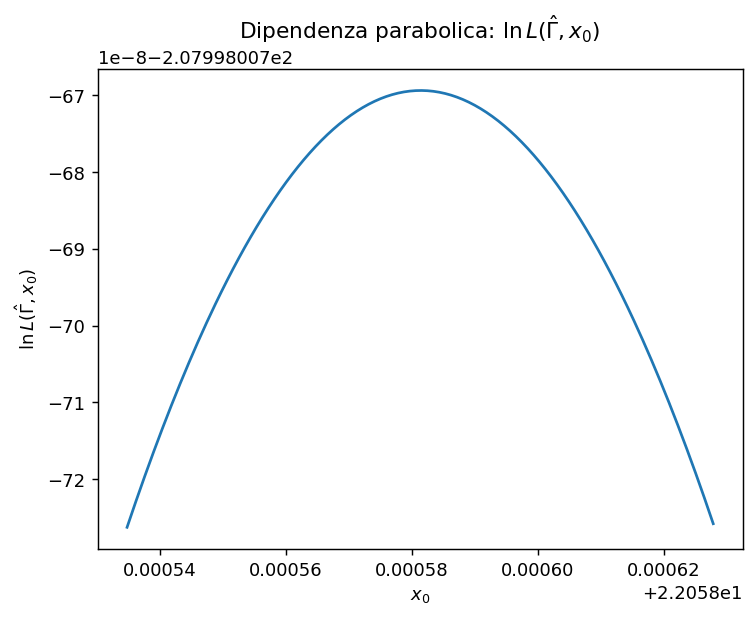

In [162]:
plt.figure(dpi = 130)
plt.title("Dipendenza parabolica: $\\ln L(\\hat{\\Gamma}, x_0)$")
plt.xlabel("$x_0$")
plt.ylabel("$\\ln L (\\hat{\\Gamma}, x_0)$")


#plt.plot(points[int(np.floor(pointsGammaInterval/2)),:,0], np.log(points[int(np.floor(pointsGammaInterval/2)),:,2]))
plt.plot(points[int(np.floor(pointsGammaInterval/2)),:,0], points[int(np.floor(pointsGammaInterval/2)),:,2])

plt.show()

#### Stima della varianza di $x_0$

In [163]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[int(np.floor(pointsGammaInterval/2)),:,2]))
max_lnL = np.max(points[int(np.floor(pointsGammaInterval/2)),:,2])


pointsx0Interval = 10000
x0IntervalEdges = [x0Estimate - 0.3, x0Estimate + 0.3]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)

#ln_L = np.log(conjCauchy(data[0:sampleSize,1], x0IntervalPoints[:], GammaEstimate))
ln_L = lnConjCauchy(data[0:sampleSize,1], x0IntervalPoints[:], GammaEstimate)

for i in range(pointsx0Interval):
    if (ln_L[i] > max_lnL - 0.5):
        stdx0 = x0Estimate - (x0IntervalPoints[i] + x0IntervalPoints[i -1])/2
        break

print(f"stdx0 = {stdx0: .4f}")

stdx0 =  0.1381


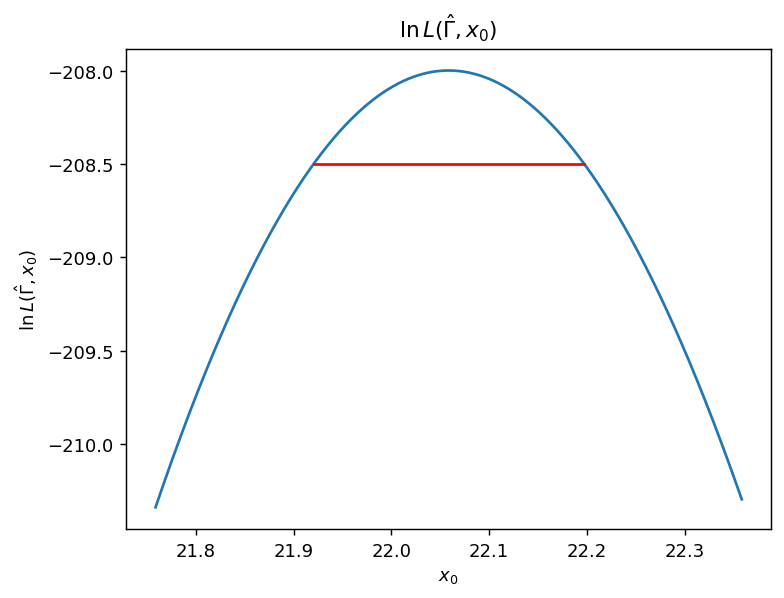

In [164]:
plt.figure(dpi = 130)
plt.title("$\\ln L(\\hat{\\Gamma}, x_0)$")
plt.xlabel("$x_0$")
plt.ylabel("$\\ln L (\\hat{\\Gamma}, x_0)$")


plt.plot(x0IntervalPoints, ln_L)
plt.plot( [x0Estimate - stdx0, x0Estimate + stdx0],  [max_lnL - 0.5, max_lnL - 0.5], color= 'red')

plt.show()

### Dipendenza parabolica $\Gamma$

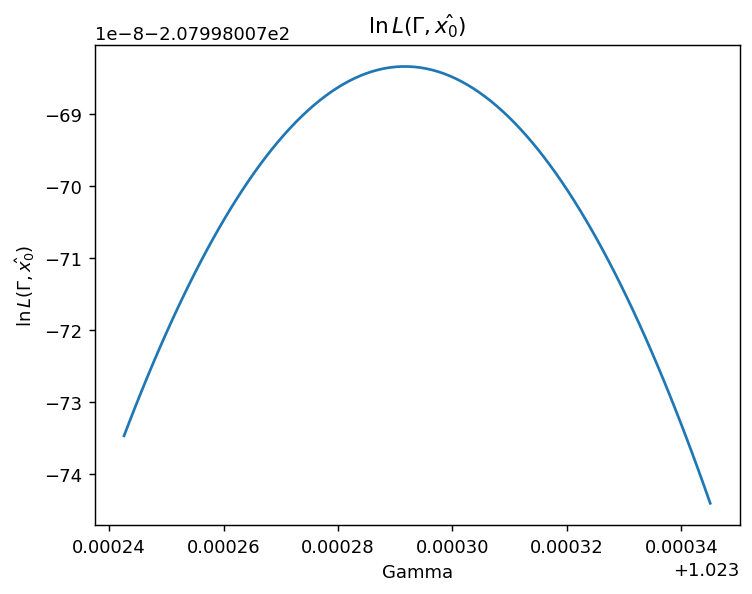

In [165]:
plt.figure(dpi = 130)
plt.title("$\\ln L (\\Gamma, \\hat{x_0})$")
plt.xlabel("Gamma")
plt.ylabel("$\\ln L (\\Gamma, \\hat{x_0})$")

#plt.plot(points[:,int(np.floor(pointsGammaInterval/2)),1], np.log(points[:,int(np.floor(pointsGammaInterval/2)),2]))
plt.plot(points[:,int(np.floor(pointsGammaInterval/2)),1], points[:,int(np.floor(pointsGammaInterval/2)),2])

plt.show()

#### Stima della varianza di $\Gamma$

In [166]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[:,int(np.floor(pointsGammaInterval/2)),2]))
max_lnL = np.max(points[:,int(np.floor(pointsGammaInterval/2)),2])

pointsGammaInterval = 10000
GammaIntervalEdges = [GammaEstimate - 0.2, GammaEstimate + 0.2]
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

#ln_L = np.log(conjCauchy(data[0:sampleSize,1], x0Estimate, GammaIntervalPoints[:]))
ln_L = lnConjCauchy(data[0:sampleSize,1], x0Estimate, GammaIntervalPoints[:])


for i in range(pointsGammaInterval-1, 0, -1):
    if (ln_L[i] > max_lnL - 0.5):
        stdGamma = (GammaIntervalPoints[i] + GammaIntervalPoints[i + 1])/2 - GammaEstimate
        break

for i in range(pointsGammaInterval):
    if (ln_L[i] > max_lnL - 0.5):
        stdGamma1 = -(GammaIntervalPoints[i] + GammaIntervalPoints[i - 1])/2 + GammaEstimate
        break

print(f"stdGammaSX = {stdGamma:.4f}")
print(f"stdGammaDX = {stdGamma1:.4f}")
stdGamma = (stdGamma + stdGamma1)/2
print(f"stdGamma = {stdGamma:.4f}")

stdGammaSX = 0.1656
stdGammaDX = 0.1422
stdGamma = 0.1539


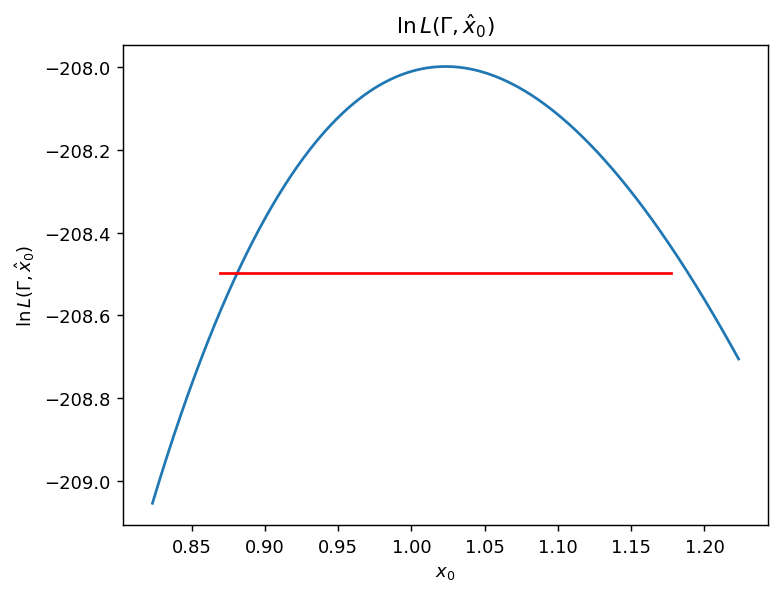

In [167]:
plt.figure(dpi = 130)
plt.title("$\\ln L(\\Gamma, \\hat{x}_0)$")
plt.xlabel("$x_0$")
plt.ylabel("$\\ln L (\\Gamma, \\hat{x}_0)$")

plt.plot(GammaIntervalPoints, ln_L)
plt.plot( [GammaEstimate - stdGamma, GammaEstimate + stdGamma],  [max_lnL - 0.5, max_lnL - 0.5], color= 'red', label="$\\sigma_{\\Gamma} =$" + f"{stdGamma}")

plt.show()

### Ellissi di confidenza

#### $Q^2 = 1$

In [168]:
pointsx0Interval = 1000
pointsGammaInterval = 1000

x0IntervalEdges = [x0Estimate - stdx0 - 0.05, x0Estimate + stdx0 + 0.05]
GammaIntervalEdges = [GammaEstimate - stdGamma - 0.015, GammaEstimate + stdGamma + 0.025]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))
points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))


# points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
# points[:,:,2] = np.log(points[:,:,2])

points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])


ellips1 = np.greater(points[:,:,2], max_lnL - 0.5)

#print(ellips)

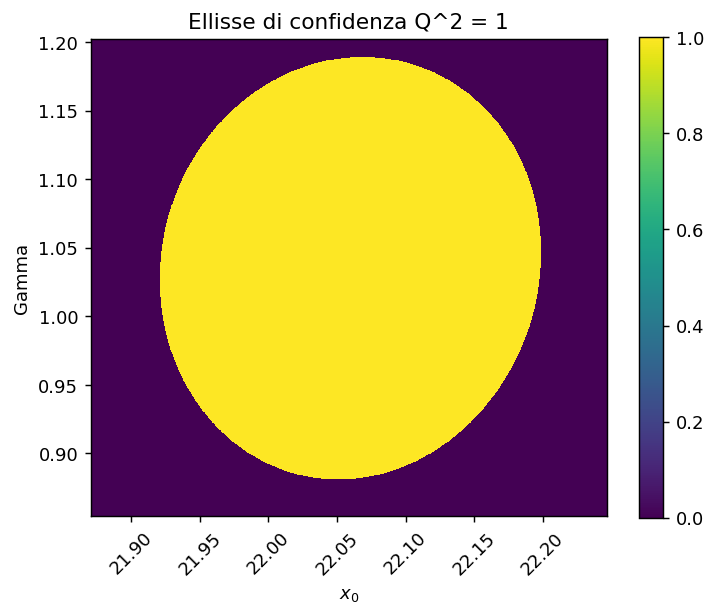

In [169]:
# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 1")
plt.imshow(ellips1[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

#### $Q^2 = 4$

In [170]:
pointsx0Interval = 1000
pointsGammaInterval = 1000

x0IntervalEdges = [x0Estimate - 2*stdx0 - 0.05, x0Estimate + 2*stdx0 + 0.05]
GammaIntervalEdges = [GammaEstimate - 2*stdGamma - 0.05, GammaEstimate + 2*stdGamma + 0.1]

x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))
points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))


# points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
# points[:,:,2] = np.log(points[:,:,2])

points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

ellips2 = np.greater(points[:,:,2], max_lnL - 2)
#print(ellips)

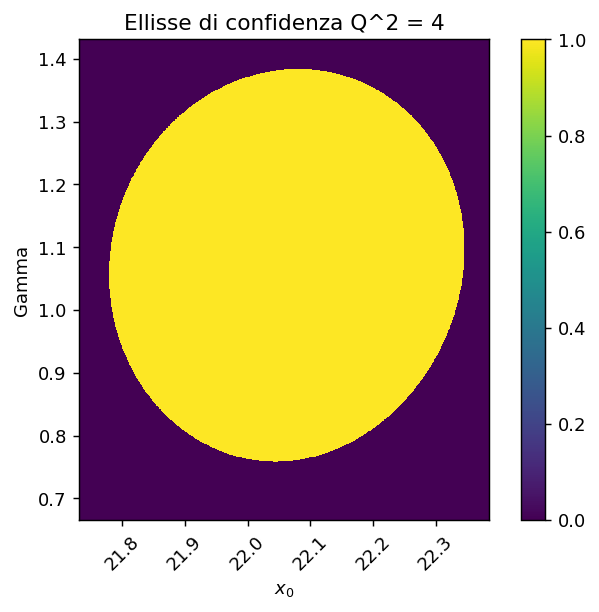

In [171]:
# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 4")
plt.imshow(ellips2[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

## 2500 Dati

In [172]:
# Number of data used to estimate parameters
sampleSize = 2500

# Defining the edges of the intervals and the number of points in the intervals
x0IntervalEdges = [np.float128(20), np.float128(24)]
GammaIntervalEdges = [np.float128(0.1), np.float128(4)]

pointsx0Interval = 200
pointsGammaInterval = 100


x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)


points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))  # points[xMatrix][yMatrix][(x, y, z)]

for i in range(pointsGammaInterval):
    points[i,:,0] = x0IntervalPoints

for j in range(pointsx0Interval):
    points[:,j,1] = GammaIntervalPoints

#points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
        


In [173]:
# Search for the maximum


precision = 0.0001
exitCondition = True # True iteration limit, False precision achieved

for k in range(1000):

    print(f"{k}: ")
    average = np.mean(points[:,:,2])
    # print(f"  Condition:  \t %1.3e" %average)
    
    # Gamma: left edge
    for i in range(pointsGammaInterval):
        if (np.max(points[i,:,2]) >= average) :
            GammaIntervalEdges[0] = points[i,0,1]
            break

    # Gamma: right edge
    for i in range(pointsGammaInterval-1, 0, -1):
        if (np.max(points[i,:,2]) >= average):
            GammaIntervalEdges[1] = points[i,0,1]
            break


    # x0: left edge
    for j in range(pointsx0Interval):
        if (np.max(points[:,j,2]) >= average):
            x0IntervalEdges[0] = points[0,j,0]
            break
        
    # x0: right edge
    for j in range(pointsx0Interval-1, 0, -1):
        if (np.max(points[:,j,2]) >= average):
            x0IntervalEdges[1] = points[0,j,0]
            break

    print(f"  Gamma in \t [ %1.6f ,"  %GammaIntervalEdges[0] + "%1.6f ]" %GammaIntervalEdges[1])
    print(f"  x0 in  \t [ %1.6f ,"  %x0IntervalEdges[0] + "%1.6f ]" %x0IntervalEdges[1])

    if (((x0IntervalEdges[1] - x0IntervalEdges[0]) <= precision) and (GammaIntervalEdges[1] - GammaIntervalEdges[0]) <= precision):
        exitCondition = False
        break

    x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

    points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
    points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
    #points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
    points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])


print("--------------------")
print("Exit Condition: ", end="")
if exitCondition:
    print("Ended for iteration limit")
else:
    print(f"Target accuracy achieved \t Accuracy = {precision}")
    print(f"Number of iterations: {k}")

GammaEstimate2500 = np.mean(GammaIntervalEdges)
x0Estimate2500 = np.mean(x0IntervalEdges)

print(f"Gamma: \t %1.5f" %GammaEstimate2500)
print(f"x0: \t %1.5f" %x0Estimate2500)

0: 
  Gamma in 	 [ 0.296970 ,4.000000 ]
  x0 in  	 [ 20.321608 ,23.658291 ]
1: 
  Gamma in 	 [ 0.371778 ,3.401530 ]
  x0 in  	 [ 20.673720 ,23.289412 ]
2: 
  Gamma in 	 [ 0.432986 ,2.789459 ]
  x0 in  	 [ 20.923460 ,23.026528 ]
3: 
  Gamma in 	 [ 0.480591 ,2.361010 ]
  x0 in  	 [ 21.124255 ,22.815165 ]
4: 
  Gamma in 	 [ 0.537573 ,2.038109 ]
  x0 in  	 [ 21.277202 ,22.653721 ]
5: 
  Gamma in 	 [ 0.598201 ,1.810755 ]
  x0 in  	 [ 21.408628 ,22.522295 ]
6: 
  Gamma in 	 [ 0.659441 ,1.639283 ]
  x0 in  	 [ 21.509362 ,22.415965 ]
7: 
  Gamma in 	 [ 0.708928 ,1.500720 ]
  x0 in  	 [ 21.595922 ,22.333960 ]
8: 
  Gamma in 	 [ 0.756916 ,1.404745 ]
  x0 in  	 [ 21.662679 ,22.263494 ]
9: 
  Gamma in 	 [ 0.802722 ,1.326220 ]
  x0 in  	 [ 21.720043 ,22.209149 ]
10: 
  Gamma in 	 [ 0.839737 ,1.262766 ]
  x0 in  	 [ 21.764284 ,22.164909 ]
11: 
  Gamma in 	 [ 0.869648 ,1.215763 ]
  x0 in  	 [ 21.802535 ,22.126658 ]
12: 
  Gamma in 	 [ 0.897617 ,1.180801 ]
  x0 in  	 [ 21.831852 ,22.097340 ]
13: 
  Ga

In [174]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[int(np.floor(pointsGammaInterval/2)),:,2]))
max_lnL = np.max(points[int(np.floor(pointsGammaInterval/2)),:,2])


pointsx0Interval = 10000
x0IntervalEdges = [x0Estimate2500 - 0.05, x0Estimate2500 + 0.05]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)

#ln_L = np.log(conjCauchy(data[0:sampleSize,1], x0IntervalPoints[:], GammaEstimate))
ln_L = lnConjCauchy(data[0:sampleSize,1], x0IntervalPoints[:], GammaEstimate2500)

for i in range(pointsx0Interval):
    if (ln_L[i] > max_lnL - 0.5):
        stdx02500 = x0Estimate2500 - (x0IntervalPoints[i] + x0IntervalPoints[i -1])/2
        break

print(f"stdx0 = {stdx02500:.5f}")

stdx0 = 0.02824


In [175]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[:,int(np.floor(pointsGammaInterval/2)),2]))
max_lnL = np.max(points[:,int(np.floor(np.size(points[0,:,0])/2)),2])

pointsGammaInterval = 10000
GammaIntervalEdges = [GammaEstimate2500 - 0.2, GammaEstimate2500 + 0.2]
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

#ln_L = np.log(conjCauchy(data[0:sampleSize,1], x0Estimate, GammaIntervalPoints[:]))
ln_L = lnConjCauchy(data[0:sampleSize,1], x0Estimate2500, GammaIntervalPoints[:])


for i in range(pointsGammaInterval-1, 0, -1):
    if (ln_L[i] > max_lnL - 0.5):
        stdGamma2500 = (GammaIntervalPoints[i] + GammaIntervalPoints[i + 1])/2 - GammaEstimate2500
        break

for i in range(pointsGammaInterval):
    if (ln_L[i] > max_lnL - 0.5):
        stdGamma1_2500 = -(GammaIntervalPoints[i] + GammaIntervalPoints[i - 1])/2 + GammaEstimate2500
        break

stdGamma2500 = (stdGamma2500 + stdGamma1_2500)/2
print(f"stdGamma2500 = {stdGamma2500:.5f}")

stdGamma2500 = 0.03018


In [176]:
print(f"x0: {x0Estimate2500:.3f} +- {stdx02500:.3f}")
print(f"Gamma: {GammaEstimate2500:.3f} +- {stdGamma2500:.3f}")

x0: 21.965 +- 0.028
Gamma: 1.028 +- 0.030


### $Q^2 = 1$

In [177]:
pointsx0Interval = 1000
pointsGammaInterval = 1000

x0IntervalEdges = [x0Estimate2500 - stdx02500 - 0.01, x0Estimate2500 + stdx02500 + 0.01]
GammaIntervalEdges = [GammaEstimate2500 - stdGamma2500 - 0.01, GammaEstimate2500 + stdGamma2500 + 0.01]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))
points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))


# points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
# points[:,:,2] = np.log(points[:,:,2])

points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])


ellips1_2500 = np.greater(points[:,:,2], max_lnL - 0.5)

#print(ellips)

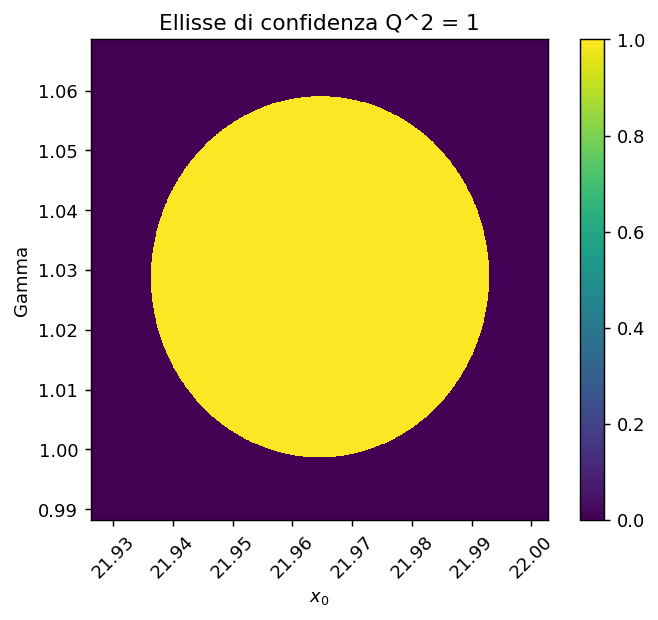

In [178]:

# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 1")
plt.imshow(ellips1_2500[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

### $Q^2 = 4$

In [179]:
pointsx0Interval = 1000
pointsGammaInterval = 1000

x0IntervalEdges = [x0Estimate2500 - 2*stdx02500 - 0.025, x0Estimate2500 + 2*stdx02500 + 0.025]
GammaIntervalEdges = [GammaEstimate2500 - 2*stdGamma2500 - 0.03, GammaEstimate2500 + 2*stdGamma2500 + 0.03]

x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))
points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))


# points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
# points[:,:,2] = np.log(points[:,:,2])

points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

ellips2_2500 = np.greater(points[:,:,2], max_lnL - 2)
#print(ellips)

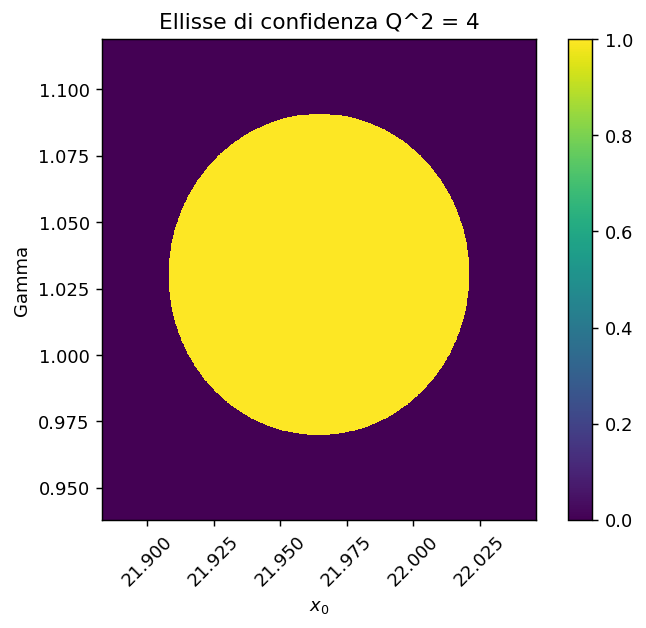

In [180]:
# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 4")
plt.imshow(ellips2_2500[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

## Binned Maximum Likelihood

### Stima di Binned $x_0$ e $\Gamma$

In [181]:
def lnBinnedConj(eventsInbins, probBins):
    var3 = np.sum(eventsInbins*np.log(probBins))
    return var3


def probabilityBins(x0, Gamma, edges):
    prob = np.empty(shape=(np.size(edges) - 1))
    for i in range(np.size(edges) -1):
        prob[i] = cauchy((edges[i+1] + edges[i])/2, x0, Gamma) * np.abs((edges[i + 1] - edges[i]))
    return prob


def probabilityBinsVectorized(x0, Gamma, edges):
    midpoints = (edges[:-1] + edges[1:]) / 2
    widths = np.abs(edges[1:] - edges[:-1])
    prob = cauchy(midpoints, x0, Gamma) * widths
    return prob

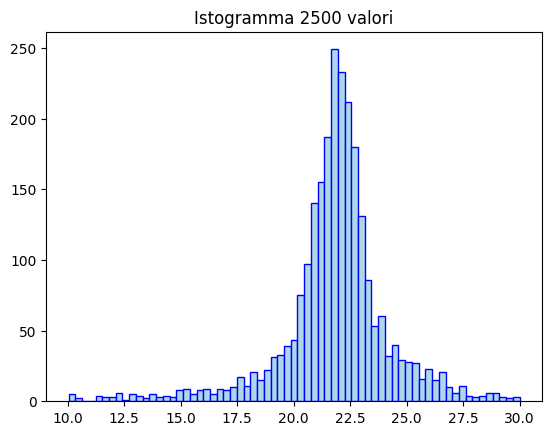

In [226]:
sampleSizeBinned = 2500
rangeData = [np.min(data[:sampleSizeBinned,1]), np.max(data[:sampleSizeBinned,1])]
# rangeData = [14, 30]
# numberBins = 1 + int(np.ceil(np.log2(sampleSizeBinned))) # Sturge
# numberBins = int(np.ceil(2*np.cbrt(sampleSizeBinned)))
numberBins = int(np.ceil((rangeData[1] - rangeData[0])/(2*(2*GammaEstimate)/np.cbrt(sampleSizeBinned))))
# numberBins = 100


plt.title("Istogramma 2500 valori")
histogram = plt.hist(data[:sampleSizeBinned,1], bins=numberBins, range=rangeData, color="lightblue", edgecolor="blue")
plt.show()

In [227]:
histogramEdges = np.array(histogram[1])
eventsInBins = np.array(histogram[0])


In [228]:
precision = 0.0001

pointsx0Interval = 200
pointsGammaInterval = 100
 
x0IntervalEdges = np.array([21, 23], dtype=np.float64)
GammaIntervalEdges = np.array([0.1, 3], dtype=np.float64)

x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

BinnedPoints = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))  # points[xMatrix][yMatrix][(x, y, z)]

BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))

for i in range(pointsx0Interval):
    for j in range(pointsGammaInterval):
        BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))

    
exitCondition = True # True iteration limit, False precision achieved


for k in range(1000):

    print(f"k: {k}")

    average = np.mean(BinnedPoints[:,:,2])

    # Gamma: left edge
    for i in range(pointsGammaInterval):
        if (np.max(BinnedPoints[i,:,2]) >= average) :
            GammaIntervalEdges[0] = BinnedPoints[i,0,1]
            break

    # Gamma: right edge
    for i in range(pointsGammaInterval-1, 0, -1):
        if (np.max(BinnedPoints[i,:,2]) >= average):
            GammaIntervalEdges[1] = BinnedPoints[i,0,1]
            break


    # x0: left edge
    for j in range(pointsx0Interval):
        if (np.max(BinnedPoints[:,j,2]) >= average):
            x0IntervalEdges[0] = BinnedPoints[0,j,0]
            break
        
    # x0: right edge
    for j in range(pointsx0Interval-1, 0, -1):
        if (np.max(BinnedPoints[:,j,2]) >= average):
            x0IntervalEdges[1] = BinnedPoints[0,j,0]
            break


    if (((x0IntervalEdges[1] - x0IntervalEdges[0]) <= precision) and (GammaIntervalEdges[1] - GammaIntervalEdges[0]) <= precision):
        exitCondition = False
        break

    x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

    BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
    BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
    #points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

    for i in range(pointsx0Interval):
        for j in range(pointsGammaInterval):
            BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))
    
#print(f"  Gamma: [{GammaIntervalEdges[0]} , {GammaIntervalEdges[1]}]")
GammaEstimateBinned = np.mean(GammaIntervalEdges)
x0EstimateBinned = np.mean(x0IntervalEdges)
print(f"GammaEstimateBinned  = {GammaEstimateBinned:.5f}")
print(f"x0EstimateBinned = {x0EstimateBinned:.5f}")

k: 0
k: 1
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
k: 45
k: 46
k: 47
k: 48
k: 49
GammaEstimateBinned  = 1.03161
x0EstimateBinned = 21.96894


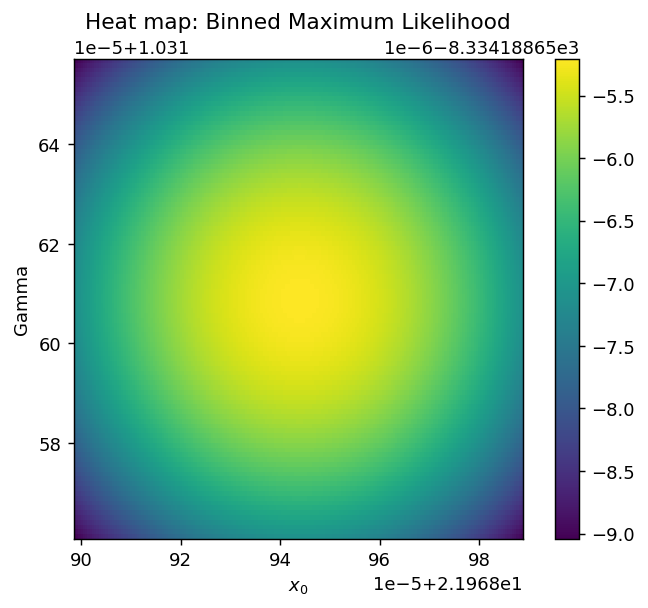

In [229]:
plt.figure(dpi = 130)
plt.title("Heat map: Binned Maximum Likelihood")
plt.xlabel("$x_0$")
plt.ylabel("Gamma")
plt.imshow(BinnedPoints[:,:,2], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
plt.colorbar()
plt.show()

### Dipendenza parabolica Binned $x_0$

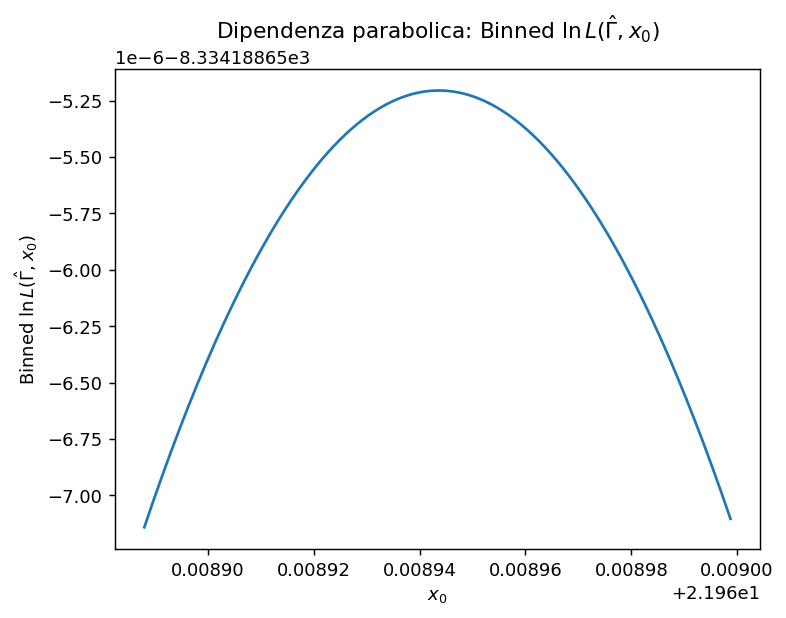

In [186]:
plt.figure(dpi = 130)
plt.title("Dipendenza parabolica: Binned $\\ln L(\\hat{\\Gamma}, x_0)$")
plt.xlabel("$x_0$")
plt.ylabel("Binned $\\ln L (\\hat{\\Gamma}, x_0)$")


#plt.plot(points[int(np.floor(pointsGammaInterval/2)),:,0], np.log(points[int(np.floor(pointsGammaInterval/2)),:,2]))
plt.plot(BinnedPoints[int(np.floor(pointsGammaInterval/2)),:,0], BinnedPoints[int(np.floor(pointsGammaInterval/2)),:,2])

plt.show()

#### Stima della varianza di Binned $x_0$

In [187]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[int(np.floor(pointsGammaInterval/2)),:,2]))
max_lnL = np.max(BinnedPoints[int(np.floor(pointsGammaInterval/2)),:,2])


pointsx0Interval = 1000
x0IntervalEdges = [x0EstimateBinned - 0.04, x0EstimateBinned + 0.04]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)

ln_BL = np.empty(shape= pointsx0Interval)
for i in range(pointsx0Interval):
        ln_BL[i] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(x0IntervalPoints[i], GammaEstimateBinned, histogramEdges ))

for i in range(pointsx0Interval):
    if (ln_BL[i] > max_lnL - 0.5):
        stdx0Binned = x0EstimateBinned - (x0IntervalPoints[i] + x0IntervalPoints[i -1])/2
        break

print(f"stdx0Binned = {stdx0Binned:.5f}")

stdx0Binned = 0.02827


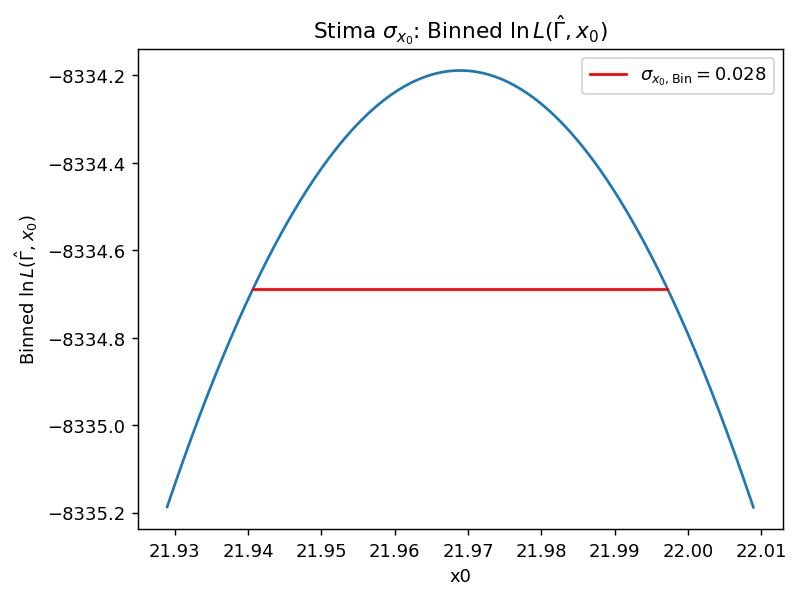

In [188]:
plt.figure(dpi = 130)
plt.title("Stima $\\sigma_{x_0}$: Binned $\\ln L(\\hat{\\Gamma}, x_0)$")
plt.xlabel("x0")
plt.ylabel("Binned $\\ln L (\\hat{\\Gamma}, x_0)$")


plt.plot(x0IntervalPoints, ln_BL)
plt.plot( [x0EstimateBinned - stdx0Binned, x0EstimateBinned + stdx0Binned],  [max_lnL - 0.5, max_lnL - 0.5], color= 'red', label="$\\sigma_{x_0, \\text{Bin}} =$" + f"{stdx0Binned:.3f}")
plt.legend()

plt.show()

### Dipendenza parabolica Binned $\Gamma$

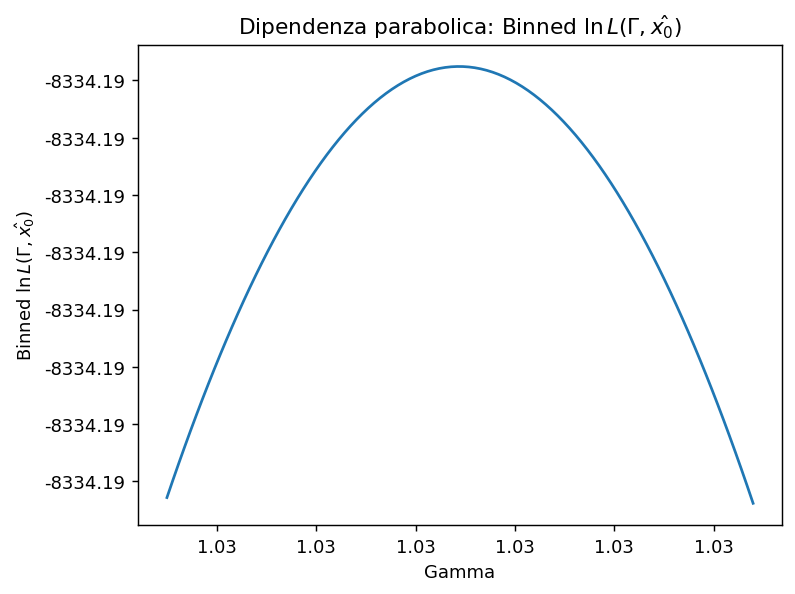

In [189]:
plt.figure(dpi = 130)
plt.title("Dipendenza parabolica: Binned $\\ln L (\\Gamma, \\hat{x_0})$")
plt.xlabel("Gamma")
plt.ylabel("Binned $\\ln L (\\Gamma, \\hat{x_0})$")

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

 
#plt.plot(points[:,int(np.floor(pointsGammaInterval/2)),1], np.log(points[:,int(np.floor(pointsGammaInterval/2)),2]))
plt.plot(BinnedPoints[:,int(np.floor(np.size(BinnedPoints[:,0,0])/2)),1], BinnedPoints[:,int(np.floor(pointsGammaInterval/2)),2])

plt.show()

In [190]:
# Estimate of the variance

#max_lnL = np.max(np.log(points[:,int(np.floor(pointsGammaInterval/2)),2]))
max_lnL = np.max(BinnedPoints[:,int(np.floor(np.size(BinnedPoints[:,0,2])/2)),2])

pointsGammaInterval = 1000
GammaIntervalEdges = [GammaEstimateBinned - 0.05, GammaEstimateBinned + 0.05]
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

ln_BL = np.empty(shape= pointsGammaInterval)
for j in range(pointsGammaInterval):
    ln_BL[j] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(x0EstimateBinned, GammaIntervalPoints[j], histogramEdges ))

for i in range(pointsGammaInterval-1, 0, -1):
    if (ln_BL[i] > max_lnL - 0.5):
        stdGammaBinned = (GammaIntervalPoints[i] + GammaIntervalPoints[i + 1])/2 - GammaEstimateBinned
        break

for i in range(pointsGammaInterval):
    if (ln_BL[i] > max_lnL - 0.5):
        stdGamma1Binned = -(GammaIntervalPoints[i] + GammaIntervalPoints[i - 1])/2 + GammaEstimateBinned
        break

print(f"stdGammaBinned = {stdGammaBinned:.5f}")
print(f"stdGamma1Binned = {stdGamma1Binned:.5f}")
stdGammaBinned = (stdGammaBinned + stdGamma1Binned)/2


stdGammaBinned = 0.03083
stdGamma1Binned = 0.02983


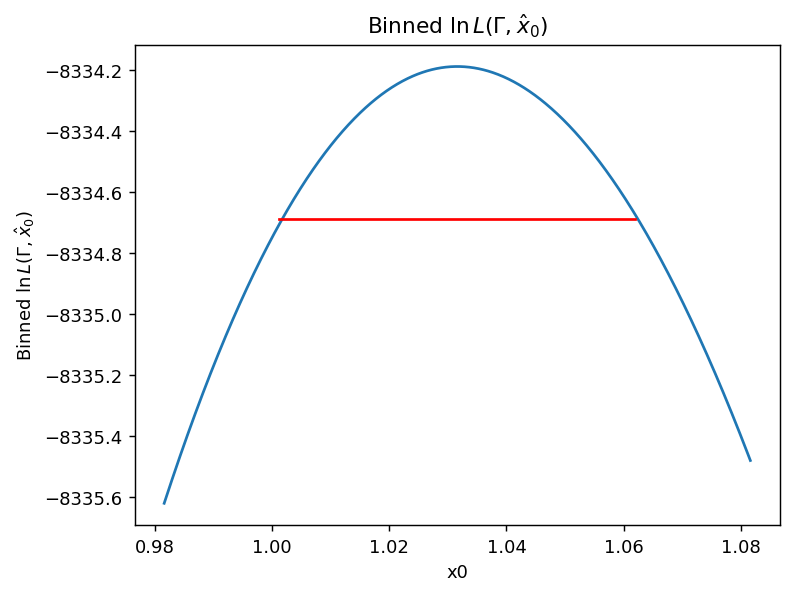

In [191]:
plt.figure(dpi = 130)
plt.title("Binned $\\ln L(\\Gamma, \\hat{x}_0)$")
plt.xlabel("x0")
plt.ylabel("Binned $\\ln L (\\Gamma, \\hat{x}_0)$")

plt.plot(GammaIntervalPoints, ln_BL)
plt.plot( [GammaEstimateBinned - stdGammaBinned, GammaEstimateBinned + stdGammaBinned],  [max_lnL - 0.5, max_lnL - 0.5], color= 'red', label="$\\sigma_{\\Gamma} =$" + f"{stdGammaBinned}")

plt.show()

### $Q^2 = 1$

In [192]:
pointsx0Interval = 800
pointsGammaInterval = 300

max_binned = np.max(BinnedPoints[:,:,2])

x0IntervalEdges = [x0EstimateBinned - stdx0Binned - 0.01, x0EstimateBinned +stdx0Binned+ 0.01]
GammaIntervalEdges = [GammaEstimateBinned - stdGammaBinned - 0.01, GammaEstimateBinned + stdGammaBinned + 0.01]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

BinnedPoints = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))

BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
#points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

for i in range(pointsx0Interval):
    for j in range(pointsGammaInterval):
        BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBins(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))

ellips3 = np.greater(BinnedPoints[:,:,2], max_binned - 0.5)

#print(ellips)

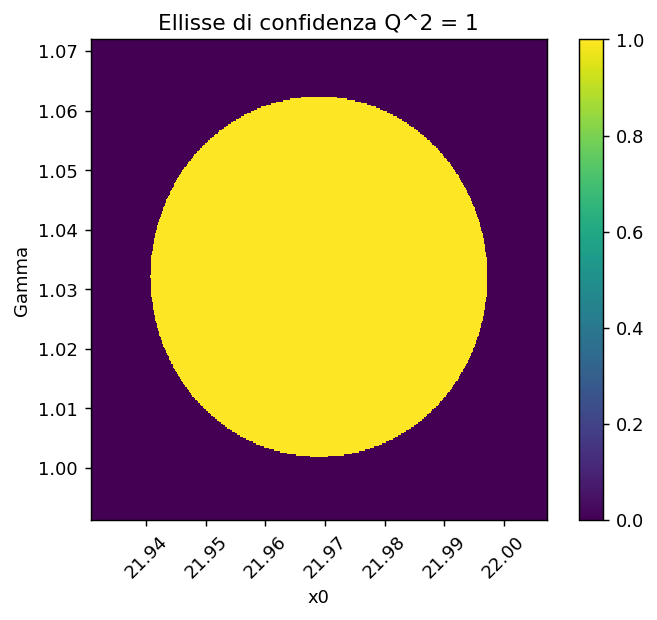

In [193]:
# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 1")
plt.imshow(ellips3[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("x0")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

### $Q^2 = 4$

In [194]:
pointsx0Interval = 800
pointsGammaInterval = 300

max_binned = np.max(BinnedPoints[:,:,2])

x0IntervalEdges = [x0EstimateBinned - 2*stdx0Binned - 0.01, x0EstimateBinned + 2*stdGammaBinned +  0.01]
GammaIntervalEdges = [GammaEstimateBinned - 2*stdGammaBinned - 0.01, GammaEstimateBinned + 2*stdGammaBinned + 0.01]
x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

BinnedPoints = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))

BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
#points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

for i in range(pointsx0Interval):
    for j in range(pointsGammaInterval):
        BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBins(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))

ellips4 = np.greater(BinnedPoints[:,:,2], max_binned - 2)

#print(ellips)

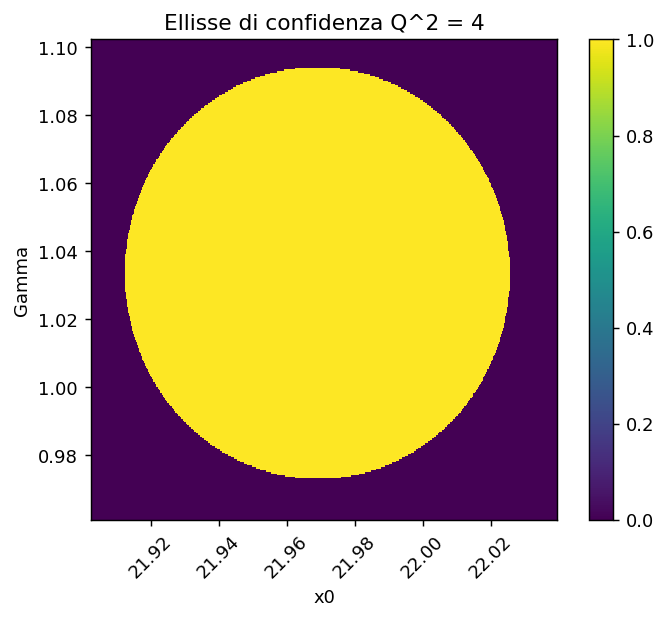

In [195]:
# Heat map ellipses

plt.figure(dpi= 130)
plt.title("Ellisse di confidenza Q^2 = 4")
plt.imshow(ellips4[:,:], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="equal", origin= "lower", interpolation="none")
#plt.imshow(points[:,:,2], origin="lower")

plt.xticks(rotation = 45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

plt.xlabel("x0")
plt.ylabel("Gamma")
plt.colorbar()

plt.show()

## Test d'ipotesi

### Test di $\chi_2$ su $x_0$

### Binned


In [196]:
from scipy import integrate
from scipy.special import gamma
# Finds the critical zone of the chi_n^2 test by bisection
def findCriticalZone(alpha, n):

    probability = np.float64(0)
    steps = 100

    marginOfError = 0.0001
    lower = 1.0 - alpha - marginOfError
    upper = 1.0 - alpha + marginOfError

    x_0 = np.float64(0)
    inf = np.float64(0)     # inteval used in bisection
    sup = np.float64(10*n)  
    x = np.float64(10*n)    # output variable

    chi_n = lambda y : (np.pow(y, (n/2.0 - 1))*np.exp(-y/2.0))/(np.pow(2.0, n/2.0) * gamma(n/2.0))
    
    for iterations in range (100):
        points = np.linspace(x_0, x, num=steps)
    
        # Probability
        probability = integrate.trapezoid(chi_n(points), points)


        # if iterations%10 == 0:
        #     print(f"{iterations} \t Probability = {probability} \t x = {x} \t [{inf}, {sup}]")

        if ( (probability >= lower) and (probability <= upper) ):
            return x
        elif (probability >= upper):
            sup = x
            x = (sup + inf)/2
        else:
            inf = x
            x = (sup + inf)/2

**Preparazione dati per fare il testi di $\chi^2$**

In [197]:
testData = np.array(histogram[0][sampleSizeBinned:])
rangeTestData = [np.min(data[sampleSizeBinned:,1]), np.max(data[sampleSizeBinned:,1])]
numberBinsTestData = int(np.ceil((rangeTestData[1] - rangeTestData[0])/(2*(2*GammaEstimate)/np.cbrt(np.size(data[:,1]) - sampleSizeBinned))))

plt.ioff()
histogramTest = plt.hist(data[sampleSizeBinned:,1], bins=numberBinsTestData, range=rangeTestData, color="lightblue", edgecolor="blue")
plt.close()

In [198]:
testDataEdges = np.array(histogramTest[1])
testData = np.array(histogramTest[0])

In [199]:
alpha = 0.05
t_alpha = findCriticalZone(alpha, numberBinsTestData)
print(f"t_alpha = {t_alpha:.2f}")

t_alpha = 119.88


In [200]:
# Using Binned Estimates
# expectedEventsBinned = (testDataEdges[1:] - testDataEdges[0:-1])*cauchy((testDataEdges[1:] + testDataEdges[0:-1])/2, x0EstimateBinned, GammaEstimateBinned)*(10000 - sampleSizeBinned)
# testBinned = np.float32(0)
# testBinned += np.sum((testData - expectedEventsBinned)**2/expectedEventsBinned)

# Using Unbinned Estimates 2500
expectedEventsBinned = (testDataEdges[1:] - testDataEdges[0:-1])*cauchy((testDataEdges[1:] + testDataEdges[0:-1])/2, x0Estimate2500, GammaEstimate2500)*(10000 - 2500)
testBinned = np.float32(0)
testBinned += np.sum((testData - expectedEventsBinned)**2/expectedEventsBinned)

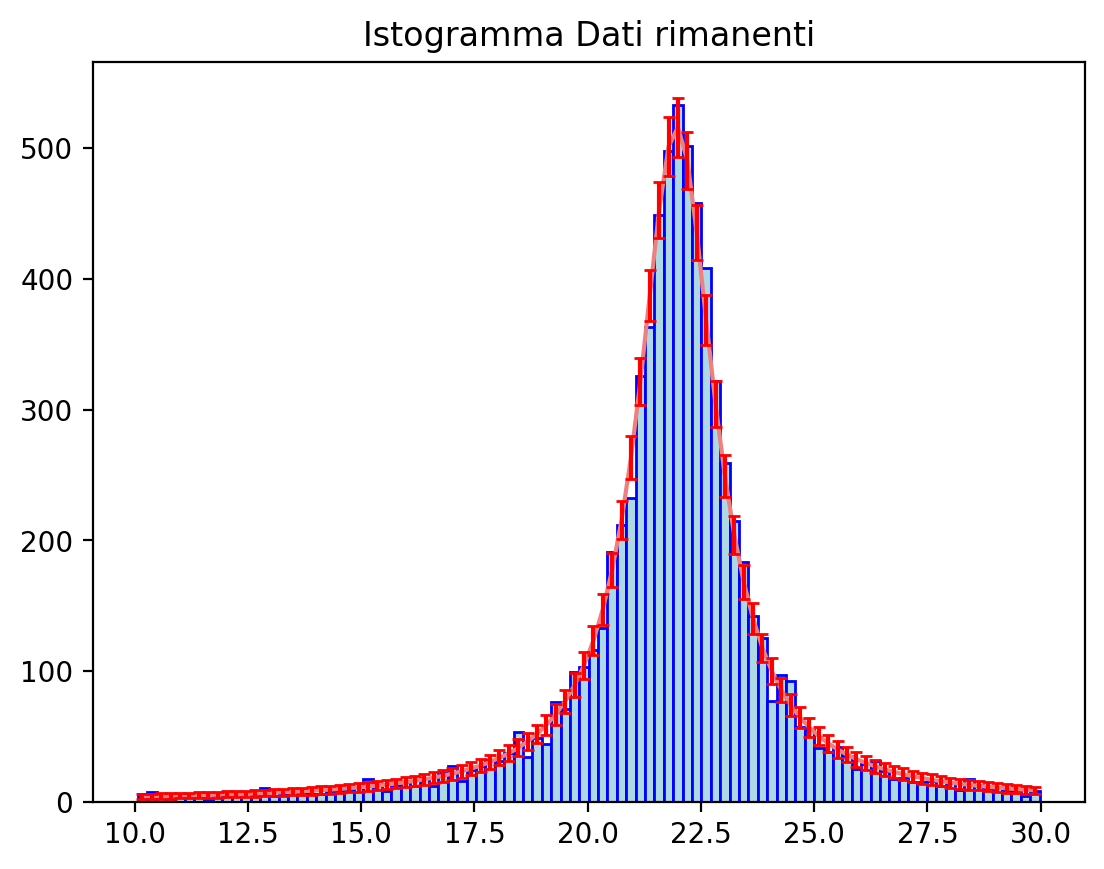

In [201]:

plt.figure(dpi = 200)
plt.title("Istogramma Dati rimanenti")
plt.bar(testDataEdges[0:-1], testData, width=(testDataEdges[1:] - testDataEdges[0:-1]), align='edge', color="lightblue", edgecolor="blue")
# plt.bar(histogramEdges[0:-1], expectedEventsBinned, width=(histogramEdges[1:] - histogramEdges[0:-1]), align='edge')
plt.errorbar((testDataEdges[1:] + testDataEdges[0:-1])/2, expectedEventsBinned , yerr=np.sqrt(expectedEventsBinned), ecolor="red", capsize=2, color="lightcoral", barsabove=True)
# plt.plot((histogramEdges[1:] + histogramEdges[0:-1])/2, expectedEventsBinned, color="yellow", zorder=1)

plt.show()


In [202]:
ChiTest = np.sum((testData - expectedEventsBinned)**2/(expectedEventsBinned))

print(f"ndf =  {numberBinsTestData} \t [{ numberBinsTestData- 2*np.sqrt(numberBinsTestData):.2f}, {numberBinsTestData + 2*np.sqrt(numberBinsTestData):.2f}]")
print(f"ChiTest = {ChiTest:.2f}")
print(f"ChiTest/ndf = {ChiTest/numberBinsTestData:.2f}")

ndf =  96 	 [76.40, 115.60]
ChiTest = 89.53
ChiTest/ndf = 0.93


## Compatibilità delle stime ottenute

In [250]:
SGammaU_B = GammaEstimate2500 - GammaEstimateBinned
stdSGammaU_B = np.absolute((stdGamma2500 - stdGammaBinned))
Sx0U_B = x0Estimate2500 - x0EstimateBinned
stdSx0U_B = np.absolute( (stdx02500 - stdx0Binned))
print(f"SGammaU_B : [{SGammaU_B - stdSGammaU_B:.4f} , {SGammaU_B + stdSGammaU_B : .4f}]")
print(f"Sx0U_B : [{Sx0U_B - stdSx0U_B:.5f} , {Sx0U_B + stdSx0U_B : .5f}]")

CompTestGammaU_B = SGammaU_B**2/(stdSGammaU_B)**2
print(f"CompTestGammaU_B = {CompTestGammaU_B:.3f}")
CompTestx0U_B = Sx0U_B**2/(stdSx0U_B)**2
print(f"ComptTestx0U_B = {CompTestx0U_B:.3f}")

print("----------")

SGammaU_U = GammaEstimate2500 - GammaEstimate
stdSGammaU_U = np.absolute(stdGamma2500 - stdGamma)
Sx0U_U = x0Estimate2500 - x0Estimate
stdSx0U_U = np.absolute(stdx02500 - stdx0)
print(f"SGammaU_U : [{SGammaU_U - stdSGammaU_U:.4f} , {SGammaU_U + stdSGammaU_U : .4f}]")
print(f"Sx0U_U : [{Sx0U_U - stdSx0U_U:.4f} , {Sx0U_U + stdSx0U_U : .4f}]")

CompTestGammaU_U = SGammaU_U**2/(stdSGammaU_U)**2
print(f"CompTestGammaU_U = {CompTestGammaU_U:.3f}")
CompTestx0U_U = Sx0U_U**2/(stdSx0U_U)**2
print(f"ComptTestx0U_U = {CompTestx0U_U:.3f}")

print("----------")

column =  np.array(data[:,1])
condition = (column > 14.7) & (column < 30)
newData = column[condition]

# print((np.quantile(newData, 0.75) - np.quantile(newData, 0.25))/2)
print(f"Median = {np.quantile(data[:,1], 0.5):.4f}")
print(f"x0Estimate2500 = {x0Estimate2500:.4f}")
print(f"x0EstimateBinned = {x0EstimateBinned:.4f}")






SGammaU_B : [-0.0034 , -0.0029]
Sx0U_B : [-0.00442 , -0.00437]
CompTestGammaU_B = 481.544
ComptTestx0U_B = 29814.239
----------
SGammaU_U : [-0.1186 ,  0.1288]
Sx0U_U : [-0.2039 ,  0.0159]
CompTestGammaU_U = 0.002
ComptTestx0U_U = 0.732
----------
Median = 21.9697
x0Estimate2500 = 21.9646
x0EstimateBinned = 21.9689


## Correlazione tra $x_0$ e $\Gamma$

### Iterazioni Stime Unbinned

In [204]:
sampleSize = 100

precision = 0.001

pointsx0Interval = 200
pointsGammaInterval = 100

points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))  # points[xMatrix][yMatrix][(x, y, z)]

GammaEstimate100 = np.empty(shape=(int(np.size(data[:,1])/sampleSize)))
x0Estimate100 = np.empty(shape=(int(np.size(data[:,1])/sampleSize)))

for m in range(int(np.size(data[:,1])/sampleSize)):

    print(f"m: {m}")

    x0IntervalEdges = [np.float64(21), np.float64(24)]
    GammaIntervalEdges = [np.float64(0.3), np.float64(2)]

    x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)


    points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
    points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
    points[:,:,2] = lnConjCauchy(data[sampleSize*0 : sampleSize*(0+1) , 1], points[:,:,0], points[:,:,1])

        
    exitCondition = True # True iteration limit, False precision achieved

    # print(f"  Gamma: [{GammaIntervalEdges[0]} , {GammaIntervalEdges[1]}]")

    # x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    # GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

    for k in range(1000):

        # print(f"k: {k}")

        average = np.mean(points[:,:,2])

        # Gamma: left edge
        for i in range(pointsGammaInterval):
            if (np.max(points[i,:,2]) >= average) :
                GammaIntervalEdges[0] = points[i,0,1]
                break

        # Gamma: right edge
        for i in range(pointsGammaInterval-1, 0, -1):
            if (np.max(points[i,:,2]) >= average):
                GammaIntervalEdges[1] = points[i,0,1]
                break


        # x0: left edge
        for j in range(pointsx0Interval):
            if (np.max(points[:,j,2]) >= average):
                x0IntervalEdges[0] = points[0,j,0]
                break
            
        # x0: right edge
        for j in range(pointsx0Interval-1, 0, -1):
            if (np.max(points[:,j,2]) >= average):
                x0IntervalEdges[1] = points[0,j,0]
                break


        if (((x0IntervalEdges[1] - x0IntervalEdges[0]) <= precision) and (GammaIntervalEdges[1] - GammaIntervalEdges[0]) <= precision):
            exitCondition = False
            break

        x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
        GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

        points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
        points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
        #points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
        points[:,:,2] = lnConjCauchy(data[sampleSize*m:sampleSize*(m+1), 1], points[:,:,0], points[:,:,1])
        
    # print(f"  Gamma: [{GammaIntervalEdges[0]} , {GammaIntervalEdges[1]}]")
    print(f"  k = {k}")
    # GammaEstimate100[m] = np.mean(GammaIntervalEdges)
    GammaEstimate100[m] = (GammaIntervalEdges[1] + GammaIntervalEdges[0])/2
    x0Estimate100[m] = np.mean(x0IntervalEdges)


m: 0
  k = 39
m: 1
  k = 38
m: 2
  k = 40
m: 3
  k = 39
m: 4
  k = 38
m: 5
  k = 38
m: 6
  k = 38
m: 7
  k = 38
m: 8
  k = 38
m: 9
  k = 38
m: 10
  k = 38
m: 11
  k = 38
m: 12
  k = 39
m: 13
  k = 39
m: 14
  k = 38
m: 15
  k = 38
m: 16
  k = 38
m: 17
  k = 39
m: 18
  k = 40
m: 19
  k = 38
m: 20
  k = 38
m: 21
  k = 38
m: 22
  k = 39
m: 23
  k = 40
m: 24
  k = 40
m: 25
  k = 39
m: 26
  k = 38
m: 27
  k = 39
m: 28
  k = 38
m: 29
  k = 38
m: 30
  k = 38
m: 31
  k = 39
m: 32
  k = 38
m: 33
  k = 39
m: 34
  k = 40
m: 35
  k = 38
m: 36
  k = 38
m: 37
  k = 38
m: 38
  k = 38
m: 39
  k = 39
m: 40
  k = 38
m: 41
  k = 39
m: 42
  k = 39
m: 43
  k = 38
m: 44
  k = 39
m: 45
  k = 39
m: 46
  k = 38
m: 47
  k = 39
m: 48
  k = 39
m: 49
  k = 39
m: 50
  k = 38
m: 51
  k = 39
m: 52
  k = 38
m: 53
  k = 38
m: 54
  k = 38
m: 55
  k = 38
m: 56
  k = 39
m: 57
  k = 39
m: 58
  k = 38
m: 59
  k = 40
m: 60
  k = 37
m: 61
  k = 39
m: 62
  k = 38
m: 63
  k = 38
m: 64
  k = 38
m: 65
  k = 39
m: 66
  k = 38
m: 67

#### Istogramma stime di $\Gamma$

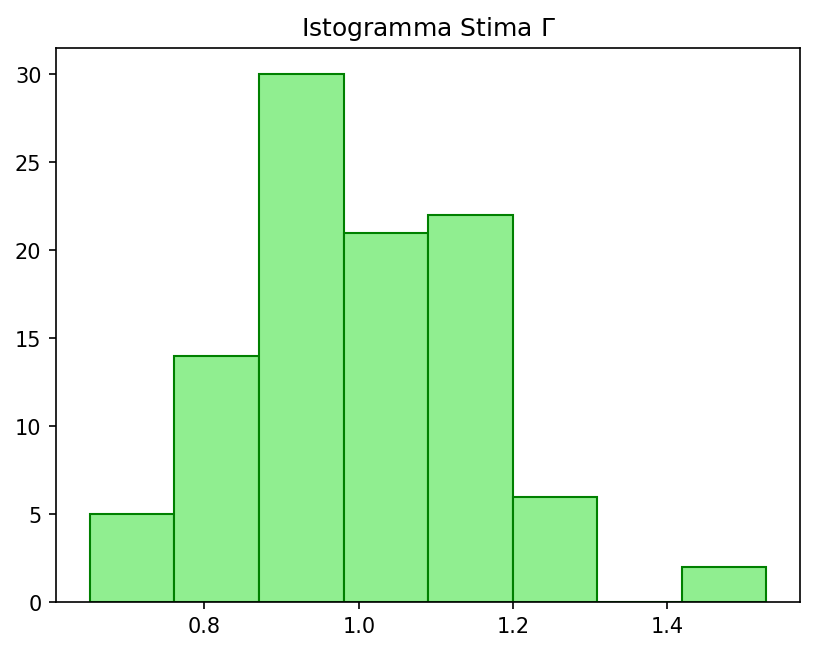

In [235]:
plt.figure(dpi = 150)
plt.title("Istogramma Stima $\\Gamma$")
# plt.hist(np.log(GammaEstimate100), bins=10, edgecolor="green", color="lightgreen", density = True)
plt.hist(GammaEstimate100, bins=8, edgecolor="green", color="lightgreen", density = False)

# cauchyplot = np.empty(shape= (1000,2))
# cauchyplot[:, 0] = np.linpointsx0Interval = 1000
# pointsGammaInterval = 1000

# x0IntervalEdges = [x0Estimate - stdx0 - 0.05, x0Estimate + stdx0 + 0.05]
# GammaIntervalEdges = [GammaEstimate - stdGamma - 0.015, GammaEstimate + stdGamma + 0.025]
# x0IntervalPoints = np.linspace(x0IntervalEdges[0], x0IntervalEdges[1], num= pointsx0Interval)
# GammaIntervalPoints = np.linspace(GammaIntervalEdges[0], GammaIntervalEdges[1], num= pointsGammaInterval)

# points = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3))
# points[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
# points[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))


# # points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])
# # points[:,:,2] = np.log(points[:,:,2])

# points[:,:,2] = lnConjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])


# ellips1 = np.greater(points[:,:,2], max_lnL - 0.5)

#print(ellips)space(np.min(data[:,1]), np.max(data[:,1]), num= 1000)
# cauchyplot[:, 1] = cauchy(cauchyplot[:, 0], x0Estimate, GammaEstimate)

# plt.plot(cauchyplot[:,0], cauchyplot[:,1], color="red", label=f"Gamma= %1.3f" %GammaEstimate + "\n x_0 = %1.3f" %x0Estimate)

# plt.legend()

plt.show()


#### Istogramma Stime di $x_0$

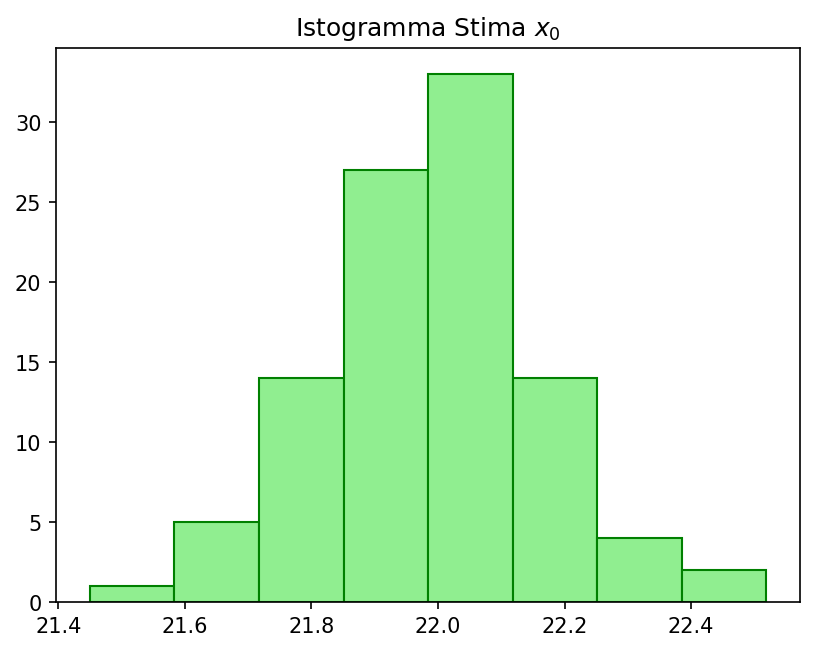

In [236]:
plt.figure(dpi = 150)
plt.title("Istogramma Stima $x_0$")
plt.hist(x0Estimate100, bins=8, edgecolor="green", color="lightgreen", density = False)

# cauchyplot = np.empty(shape= (1000,2))
# cauchyplot[:, 0] = np.linspace(np.min(data[:,1]), np.max(data[:,1]), num= 1000)
# cauchyplot[:, 1] = cauchy(cauchyplot[:, 0], x0Estimate, GammaEstimate)

# plt.plot(cauchyplot[:,0], cauchyplot[:,1], color="red", label=f"Gamma= %1.3f" %GammaEstimate + "\n x_0 = %1.3f" %x0Estimate)

# plt.legend()

plt.show()


#### Scatter plot Stime Unbinned $x_0$ - $\Gamma$

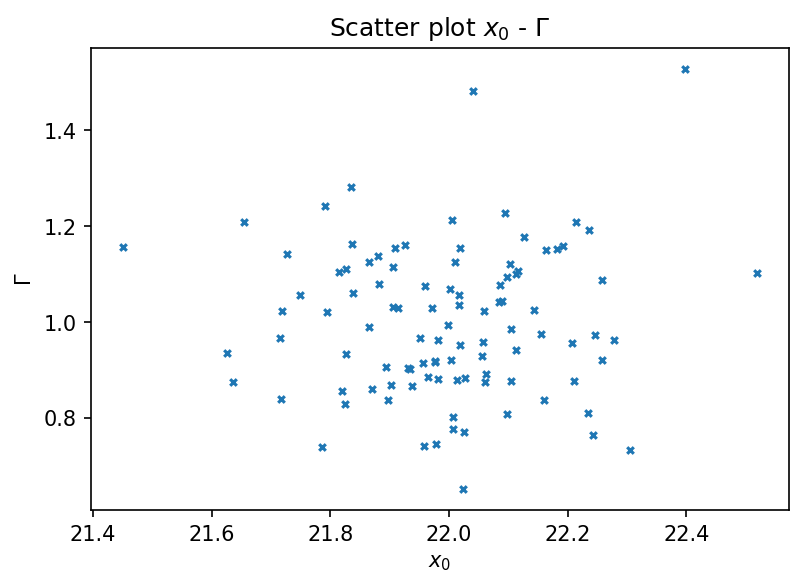

In [207]:
plt.figure(dpi=150, figsize=(6, 4))
plt.title("Scatter plot $x_0$ - $\\Gamma$")
plt.xlabel("$x_0$")
plt.ylabel("$Gamma$")
plt.scatter(x0Estimate100, GammaEstimate100,s=10, marker='x')
plt.show()

In [208]:
print(np.corrcoef(x0Estimate100, GammaEstimate100))
print(np.cov(x0Estimate100, GammaEstimate100))

n = np.size(data[:,1])/sampleSize
R = (n * np.sum(x0Estimate100*GammaEstimate100) - (np.sum(x0Estimate100)*np.sum(GammaEstimate100))) \
    /np.sqrt( (n*np.sum(x0Estimate100**2) - (np.sum(x0Estimate100))**2 ) * (n* np.sum(GammaEstimate100**2) - (np.sum(GammaEstimate100)**2)))
    

stdx0New = (np.sum(x0Estimate100 - x0Estimate2500))**2/n
stdGammaNew = (np.sum(GammaEstimate100 - GammaEstimate2500))**2/n

print(stdx0New)
print(stdGammaNew)
R2 = (n * np.sum(x0Estimate100*GammaEstimate100) - (np.sum(x0Estimate100)*np.sum(GammaEstimate100)))/(stdx0New *stdGammaNew)


print(R)
print(R2)



[[1.         0.03803797]
 [0.03803797 1.        ]]
[[0.03066936 0.0010319 ]
 [0.0010319  0.02399563]]
0.09229656853104387
0.07950163788143354
0.03803797375699362
1392.2247955205141


### Iterazioni Stime Binned

In [233]:
precision = 0.001
sampleSize = 100

# numberBins = 13
numberBins = int(np.ceil((rangeData[1] - rangeData[0])/(2*(2*GammaEstimate)/np.cbrt(sampleSizeBinned))))

pointsx0Interval = 200
pointsGammaInterval = 100

GammaEstimateBinned100 = np.empty(shape=(int(np.size(data[:,1])/sampleSize)))
x0EstimateBinned100 = np.empty(shape=(int(np.size(data[:,1])/sampleSize)))

BinnedPoints = np.empty(shape = (pointsGammaInterval, pointsx0Interval, 3), dtype=np.float64)  # points[xMatrix][yMatrix][(x, y, z)]
 
for m in range(int(np.size(data[:,1])/sampleSize)):
# for m in range(1):

    print(f"m: {m}")

    rangeData = [np.min(data[m*sampleSize:(m+1)*sampleSize,1]), np.max(data[:sampleSize,1])]
    histogram = plt.hist(data[m*sampleSize:(m+1)*sampleSize,1], bins=numberBins, range=rangeData, color="lightblue", edgecolor="blue")
    plt.close()

    histogramEdges = np.array(histogram[1])
    eventsInBins = np.array(histogram[0])


    x0IntervalEdges = np.array([21, 23], dtype=np.float32)
    GammaIntervalEdges = np.array([0.1, 3], dtype=np.float32)

    x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
    GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)


    BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
    BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))

    for i in range(pointsx0Interval):
        for j in range(pointsGammaInterval):
            BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))


    # plt.figure(dpi= 130)
    # plt.title("Heatmap")
    # plt.imshow(BinnedPoints[:,:,2], extent=[x0IntervalEdges[0], x0IntervalEdges[1], GammaIntervalEdges[0], GammaIntervalEdges[1]], aspect="auto", origin= "lower", interpolation="none")
    # #plt.imshow(points[:,:,2], origin="lower")

    # plt.xticks(rotation = 45)
    # # plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%1.5e'))
    # # plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

    # plt.xlabel("$x_0$")
    # plt.ylabel("Gamma")
    # plt.colorbar()

    # plt.show()
        
    exitCondition = True # True iteration limit, False precision achieved

    for k in range(1000):

        # print(f"  k: {k}")

        average = np.mean(BinnedPoints[:,:,2])
        # print(f"  average = {average}")

        # Gamma: left edge
        for i in range(pointsGammaInterval):
            if (np.max(BinnedPoints[i,:,2]) >= average) :
                GammaIntervalEdges[0] = BinnedPoints[i,0,1]
                # print(GammaIntervalEdges[0])
                break

        # Gamma: right edge
        for i in range(pointsGammaInterval-1, 0, -1):
            if (np.max(BinnedPoints[i,:,2]) >= average):
                GammaIntervalEdges[1] = BinnedPoints[i,0,1]
                break


        # x0: left edge
        for j in range(pointsx0Interval):
            if (np.max(BinnedPoints[:,j,2]) >= average):
                x0IntervalEdges[0] = BinnedPoints[0,j,0]
                break
            
        # x0: right edge
        for j in range(pointsx0Interval-1, 0, -1):
            if (np.max(BinnedPoints[:,j,2]) >= average):
                x0IntervalEdges[1] = BinnedPoints[0,j,0]
                break


        if (((x0IntervalEdges[1] - x0IntervalEdges[0]) <= precision) and (GammaIntervalEdges[1] - GammaIntervalEdges[0]) <= precision):
            exitCondition = False
            break

        x0IntervalPoints = np.linspace(start= x0IntervalEdges[0], stop= x0IntervalEdges[1], num= pointsx0Interval)
        GammaIntervalPoints = np.linspace(start= GammaIntervalEdges[0], stop= GammaIntervalEdges[1], num= pointsGammaInterval)

        BinnedPoints[:,:,0] = np.tile(x0IntervalPoints, (pointsGammaInterval, 1))
        BinnedPoints[:,:,1] = np.tile(GammaIntervalPoints[:, np.newaxis], (1, pointsx0Interval))
        #points[:,:,2] = conjCauchy(data[0:sampleSize, 1], points[:,:,0], points[:,:,1])

        for i in range(pointsx0Interval):
            for j in range(pointsGammaInterval):
                BinnedPoints[j,i,2] = lnBinnedConj(eventsInBins[:], probabilityBinsVectorized(BinnedPoints[j,i,0], BinnedPoints[j,i,1], histogramEdges ))
        
        print(f"  Gamma: [{GammaIntervalEdges[0]} , {GammaIntervalEdges[1]}]")
        print(f"  x0: [{x0IntervalEdges[0]} , {x0IntervalEdges[1]}]")
    GammaEstimateBinned100[m] = np.mean(GammaIntervalEdges)
    x0EstimateBinned100[m] = np.mean(x0IntervalEdges)
    print(f"  k = {k}")

m: 0
  Gamma: [0.3929292857646942 , 2.8535354137420654]
  x0: [21.0 , 23.0]
  Gamma: [0.46749311685562134 , 2.356443166732788]
  x0: [21.221105575561523 , 22.949748992919922]
  Gamma: [0.5247340202331543 , 2.0702385902404785]
  x0: [21.368778228759766 , 22.78470230102539]
  Gamma: [0.587178647518158 , 1.8516823053359985]
  x0: [21.489736557006836 , 22.649513244628906]
  Gamma: [0.6382697224617004 , 1.6728637218475342]
  x0: [21.58881378173828 , 22.5329532623291]
  Gamma: [0.6905219554901123 , 1.5370080471038818]
  x0: [21.669469833374023 , 22.44281005859375]
  Gamma: [0.7418241500854492 , 1.434403657913208]
  x0: [21.73941993713379 , 22.372859954833984]
  Gamma: [0.7837986946105957 , 1.350454568862915]
  x0: [21.796716690063477 , 22.312381744384766]
  Gamma: [0.8238652944564819 , 1.281769037246704]
  x0: [21.840768814086914 , 22.263147354125977]
  Gamma: [0.856242299079895 , 1.2308908700942993]
  x0: [21.88109588623047 , 22.222820281982422]
  Gamma: [0.8865169286727905 , 1.193047523498

#### Istogramma Stime $\Gamma$

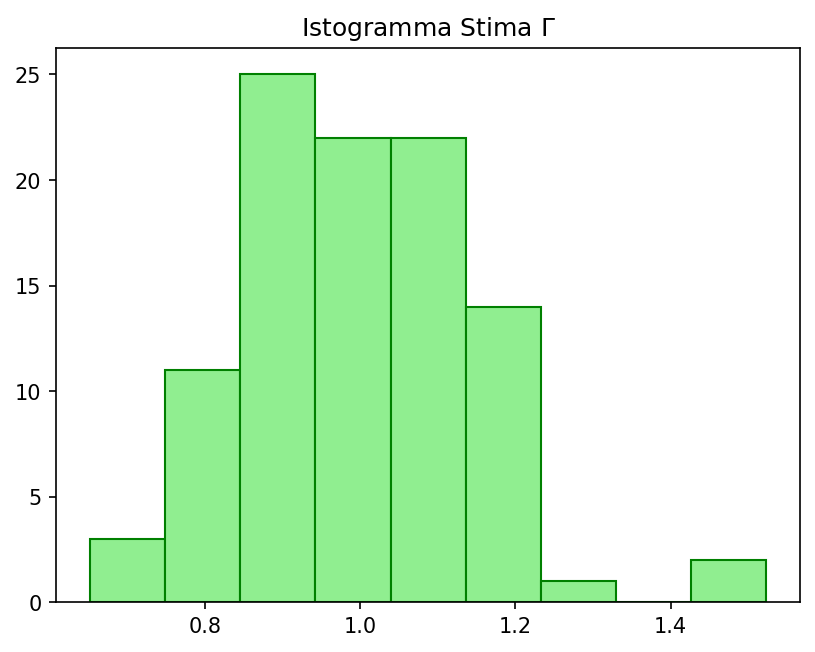

In [237]:
plt.figure(dpi = 150)
plt.title("Istogramma Stima $\\Gamma$")
# plt.hist(np.log(GammaEstimate100), bins=10, edgecolor="green", color="lightgreen", density = True)
plt.hist(GammaEstimateBinned100, bins=9, edgecolor="green", color="lightgreen", density = False)

plt.show()


#### Istogramma Stime di $x_0$

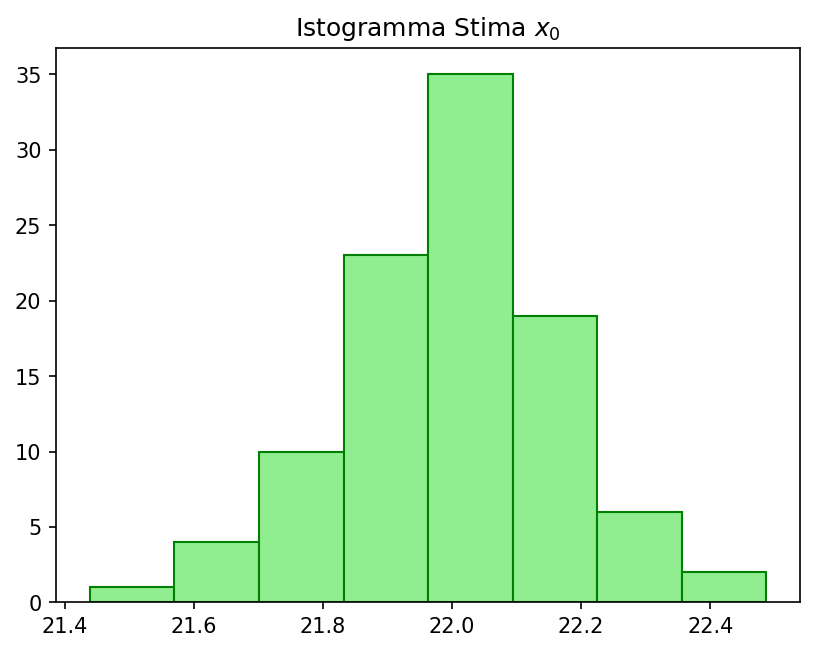

In [238]:
plt.figure(dpi = 150)
plt.title("Istogramma Stima $x_0$")
plt.hist(x0EstimateBinned100, bins=8, edgecolor="green", color="lightgreen", density = False)


plt.show()


#### Scatter plot Stime Binned $x_0$ - $\Gamma$

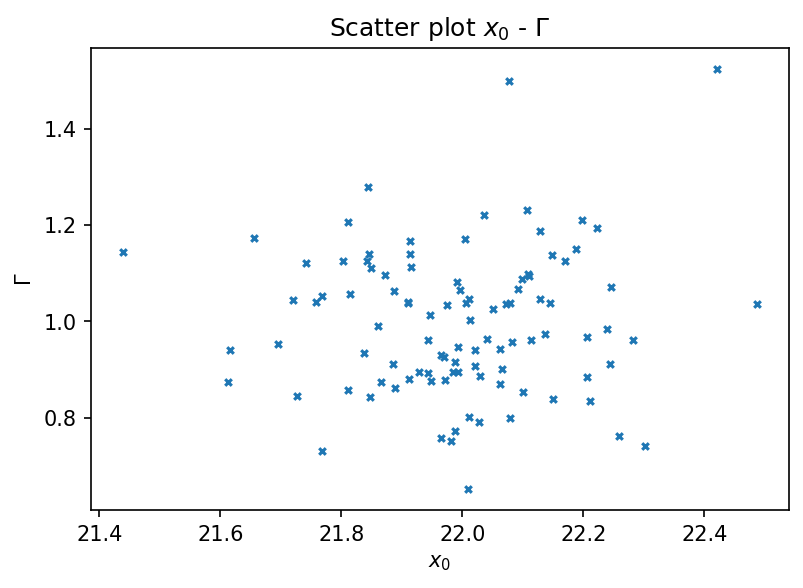

In [239]:
plt.figure(dpi=150, figsize=(6, 4))
plt.title("Scatter plot $x_0$ - $\\Gamma$ Binned")
plt.xlabel("$x_0$")
plt.ylabel("$Gamma$")
plt.scatter(x0EstimateBinned100, GammaEstimateBinned100,s=10, marker='x')
plt.show()

In [240]:
print(np.corrcoef(x0EstimateBinned100, GammaEstimateBinned100))
print(np.cov(x0EstimateBinned100, GammaEstimateBinned100))

n = np.size(data[:,1])/sampleSize
R3 = (n * np.sum(x0EstimateBinned100*GammaEstimateBinned100) - (np.sum(x0EstimateBinned100)*np.sum(GammaEstimateBinned100))) \
    /np.sqrt( (n*np.sum(x0EstimateBinned100**2) - (np.sum(x0EstimateBinned100))**2 ) * (n* np.sum(GammaEstimateBinned100**2) - (np.sum(GammaEstimateBinned100)**2)))
    

stdx0New = (np.sum(x0EstimateBinned100 - x0Estimate2500))**2/n
stdGammaNew = (np.sum(GammaEstimateBinned100 - GammaEstimate2500))**2/n

print(stdx0New)
print(stdGammaNew)


print(R)
print(R2)

[[1.         0.04790246]
 [0.04790246 1.        ]]
[[0.03040921 0.00125769]
 [0.00125769 0.02266852]]
0.08263553465739294
0.09734391178043061
0.03803797375699362
1547.8593564318396


### Correlazione $\Gamma$ Unbinned - Binned

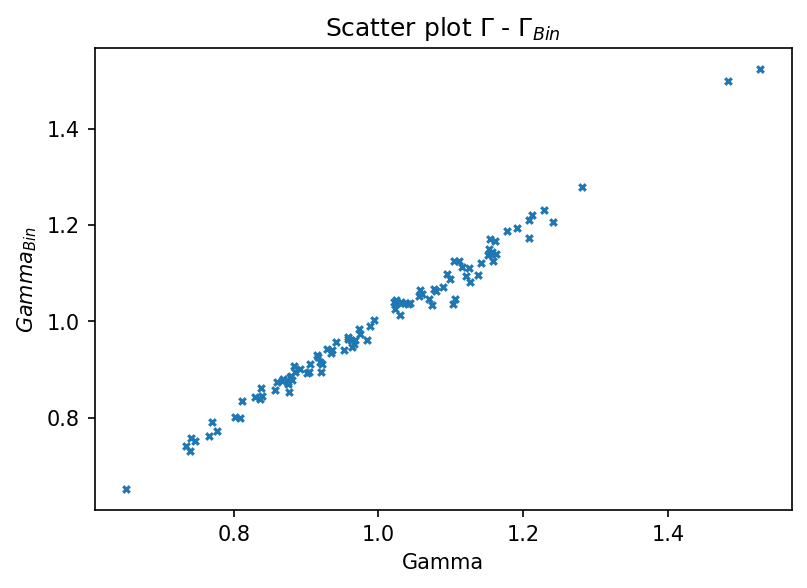

In [246]:
plt.figure(dpi=150, figsize=(6, 4))
plt.title("Scatter plot $\\Gamma$ - $\\Gamma_{Bin}$")
plt.xlabel("Gamma")
plt.ylabel("$Gamma_{Bin}$")
plt.scatter(GammaEstimate100, GammaEstimateBinned100,s=10, marker='x')
plt.show()

In [245]:
print(np.corrcoef(GammaEstimate100, GammaEstimateBinned100))
print(np.cov(GammaEstimate100, GammaEstimateBinned100))

n = np.size(data[:,1])/sampleSize
R3 = (n * np.sum(GammaEstimate100*GammaEstimateBinned100) - (np.sum(GammaEstimate100)*np.sum(GammaEstimateBinned100))) \
    /np.sqrt( (n*np.sum(GammaEstimate100**2) - (np.sum(GammaEstimate100))**2 ) * (n* np.sum(GammaEstimateBinned100**2) - (np.sum(GammaEstimateBinned100)**2)))

print(R3)

[[1.         0.99381064]
 [0.99381064 1.        ]]
[[0.02399563 0.02317829]
 [0.02317829 0.02266852]]
0.9938106367618629


### Correlazione $x_0$ Unbinned - Binned

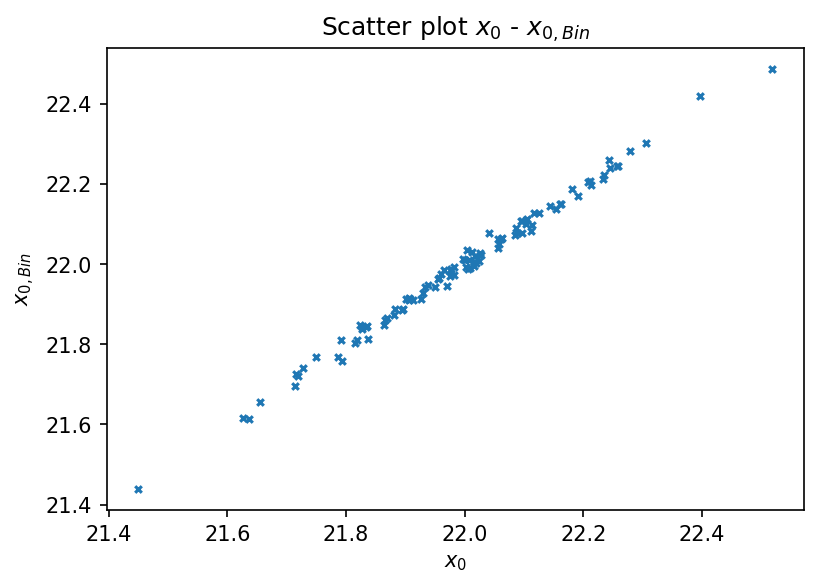

In [247]:

plt.figure(dpi=150, figsize=(6, 4))
plt.title("Scatter plot $x_0$ - $x_{0,Bin}$")
plt.xlabel("$x_0$")
plt.ylabel("$x_{0, Bin}$")
plt.scatter(x0Estimate100, x0EstimateBinned100,s=10, marker='x')
plt.show()

In [249]:
print(np.corrcoef(x0Estimate100, x0EstimateBinned100))
print(np.cov(x0Estimate100, x0EstimateBinned100))

n = np.size(data[:,1])/sampleSize
R4 = (n * np.sum(x0Estimate100*x0EstimateBinned100) - (np.sum(x0Estimate100)*np.sum(x0EstimateBinned100))) \
    /np.sqrt( (n*np.sum(x0Estimate100**2) - (np.sum(x0Estimate100))**2 ) * (n* np.sum(x0EstimateBinned100**2) - (np.sum(x0EstimateBinned100)**2)))


[[1.       0.996713]
 [0.996713 1.      ]]
[[0.03066936 0.03043863]
 [0.03043863 0.03040921]]


### Compatibilità corretta calcolando il coefficiente di correlazione

In [256]:
SGammaU_B = GammaEstimate2500 - GammaEstimateBinned
stdSGammaU_B = np.sqrt((stdGamma2500**2 + stdGammaBinned**2 - 2*R3*stdGamma2500*stdGammaBinned))
Sx0U_B = x0Estimate2500 - x0EstimateBinned
stdSx0U_B = np.sqrt(stdx02500**2 + stdx0Binned**2 - 2* R4*stdx02500*stdx0Binned)


print(f"SGammaU_B : [{SGammaU_B - 2*stdSGammaU_B:.4f} , {SGammaU_B + 2*stdSGammaU_B : .4f}]")
print(f"Sx0U_B : [{Sx0U_B - 2*stdSx0U_B:.5f} , {Sx0U_B + 2*stdSx0U_B : .5f}]")

SGammaU_B : [-0.0100 ,  0.0035]
Sx0U_B : [-0.00898 ,  0.00019]
